# Noise and SNR
This is a demo that tries to teach basic noise propagation and how to characterize SNR in images.

NOTE:  This is somewhat of a work-in-progress!  Although it is on the class GitHub, please don't treat it as complete!

## Dependencies
Signal-to-Noise depends on numerous factors:

- noise coupling to coil
- coil covariance matrix
- number of channels
- acceleration (R)
- signal level
- reconstruction process


## Initialization
Using numpy, matplotlib and mrsigpy libraries for this work.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mrsigpy as mrs
from scipy import signal as sig

%matplotlib inline






## A. Single-Channel Noise
Noise is assumed to be gaussian, 2D (real and imaginary) in k-space, with zero mean and variance $\sigma^2$. A Fourier transform (normalized by $\sqrt{1/N}$) will preserve the noise statistics (mean, variance, real, imaginary).  Usually a magnitude image is taken, which changes the noise distribution to Rician, where the mean and variance will depend on the signal level.  If the signal is zero, as in the background, the distribution is Rayleigh.

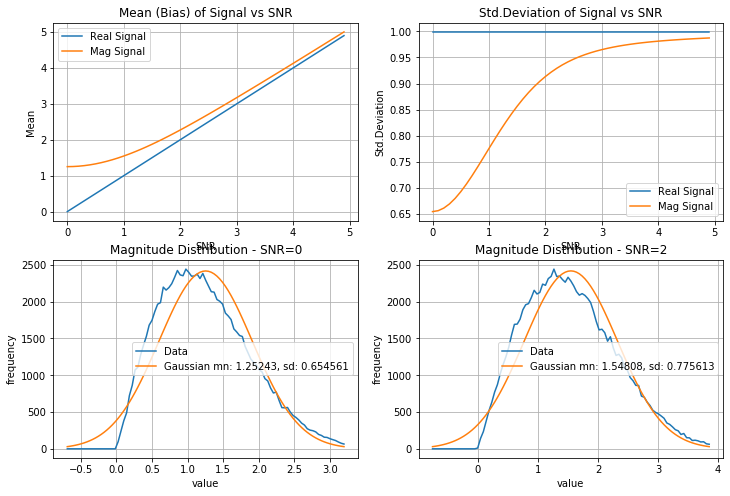

In [2]:
# This part is done a bit verbosely to show code.
#
# Generate gaussian noise,
Nn = 100000    # Lots of samples!  
cnoise = np.random.normal(0.0,1.0,(1,Nn)) + 1j*np.random.normal(0.0,1.0,(1,Nn))  # Complex gaussian noise sig=1
sig = np.arange(0.0,5.0,0.1)  # Signal (and SNR) from 0 to 10
sig = np.expand_dims(sig,axis=1)
csig = sig+cnoise            # Generate complex signal distributions
rsig = np.real(csig)         # Real-value of signal and mean/std
#print("cSig",csig)
rmean = np.mean(rsig,axis=1)   
#print("rmean",rmean)
rstd = np.std(rsig,axis=1)
msig = np.abs(csig)            # Magnitude of signal
mmean = np.mean(msig,axis=1)   # Mean of Magnitude Signal     
mstd = np.std(msig,axis=1)     # Std Deviation of Magnitude Signal


# -- Plot these!
fig = plt.figure(figsize=(12.,8.))
plt.subplot(2,2,1)
plt.plot(sig,rmean,label='Real Signal')
plt.plot(sig,mmean,label='Mag Signal')
mrs.lplot('SNR','Mean','Mean (Bias) of Signal vs SNR')
plt.legend()
plt.subplot(2,2,2)
plt.plot(sig,rstd,label='Real Signal')
plt.plot(sig,mstd,label='Mag Signal')
mrs.lplot('SNR','Std.Deviation','Std.Deviation of Signal vs SNR')
plt.legend()
plt.subplot(2,2,3)
h=mrs.ghist(msig[0,:],bins=100,gtitle='Magnitude Distribution - SNR=0')
plt.subplot(2,2,4)
snrplot = 2.   # note plot title not currently changing with this
h=mrs.ghist(msig[np.int(np.size(sig)*snrplot/10),:],bins=100,gtitle='Magnitude Distribution - SNR=2')
#
# Try changing the 3 to other things here!




### Notes - Single-Coil Magnitude Images
From the plots above we can see:
1. If we could take the real-valued signal, the noise would be gaussian, and there would be no signal bias.
1. At quite low SNR, say 4, the Rician distribution (magnitude signal) is very close to gaussian.
1. The background mean and standard deviation are $\sqrt{\pi/2} = 1.25$ and $\sqrt{2-\pi/2} = 0.65$ times the actual gaussian standard deviation.


## B. Two Coils - RMS Combination
When we use multiple coils, we often use a simple "sum-of-squares" combination, which is really a root-mean-square combination:  
$ S = \sqrt{\frac{1}{N_c}\sum_{i=0}^{N_c} |S_i|^2} $
where $N_c$ is the number of coils and $S_i$ is the signal from the $i^{th}$ coil.  

Let's look more closely at the root-mean-square combination of signals from 2 coils:  $S=\sqrt{\frac{1}{2}(|S_1|^2 + |S_2|^2)}$.  We can expand this to include noise as $S = \sqrt{\frac{1}{2}(|C_1 m + N_1|^2 + |C_2 m + N_2|^2)}$ where $C_i$ is the coil sensitivity and $m$ is the magnetization (actual signal), and $N_i$ is the noise.  

We will look at the bias and standard deviation of the signal from low-signal (background) to higher signal.

To explain this a bit more, we break this down into the component histograms for $|S_i|^2 = |C_i m + N_i|^2$ for the cases where $C_i$ is 0 and 1.



Size of csig is  (50, 2, 1)
Size of cnoise is  (2, 10000)
Zero-signal mean = 1.26 and std.dev = 0.65 (with 2nd coil zeroed out - matches single coil!)
Zero-signal mean = 1.33 and std.dev = 0.48 (From both coils, normalized)
Zero-signal mean = 1.33 and std.dev = 0.48 (From 1-of-2 coils, normalized)
Shape of ssqsig2 is  (50, 2, 10000)
Shape of binp is  (199,)
Shape of s1hist is  (199,)


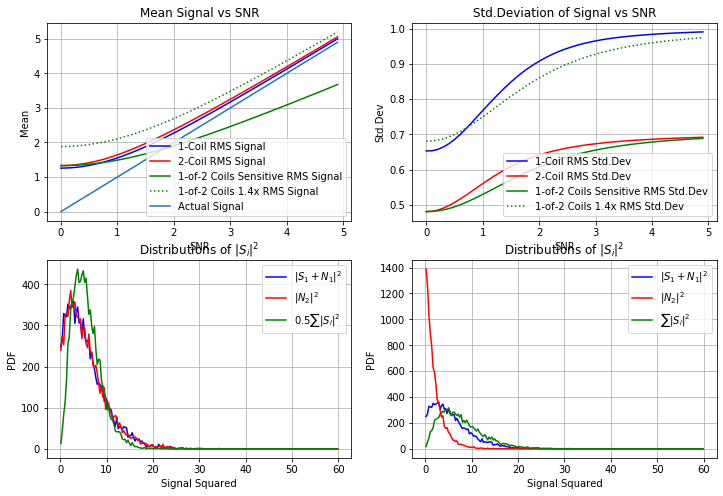

In [34]:
# -- Two-Coil Analysis

# Signal is a ramp
sig = np.arange(0.0,5.0,0.1)  # Signal (and SNR) from 0 to 10
sig = np.expand_dims(sig,axis=1)

# Generate Coil Signals
csens = np.array([[1,1]])
csig = np.matmul(sig,csens)  # NxNc array of signal
csig = np.expand_dims(csig,axis=2)
print("Size of csig is ",np.shape(csig))
print("Size of cnoise is ",np.shape(cnoise))

# Generate and add gaussian noise,
Nn = 10000    # Lots of samples!  
cnoise = np.random.normal(0.0,1.0,(2,Nn)) + 1j*np.random.normal(0.0,1.0,(2,Nn))  # Complex gaussian noise sig=1
cnsig = csig + cnoise
#print("Size of cnsig is ",np.shape(cnsig))

# (1) Sanity check - RMS, but zero-out a coil to compare to single coil case!
cnsig[:,1,:] = 0.0*cnsig[:,1,:]
rmssig = np.real(np.sqrt(np.sum(cnsig * np.conj(cnsig),axis=1)))
# Mean and Standard Deviation at zero-signal
s1mean = np.mean(rmssig,axis=1)
s1std = np.std(rmssig,axis=1)
print ("Zero-signal mean = %4.2f and std.dev = %4.2f (with 2nd coil zeroed out - matches single coil!)" % (s1mean[0],s1std[0]))

# (2) Both coils measuring Signal!
cnsig = csig + cnoise
ssqsig2 = cnsig * np.conj(cnsig)

# 
rmssig = np.real(np.sqrt(np.sum(cnsig * np.conj(cnsig),axis=1)))/np.sqrt(2)  # Normalize by sqrt(2)!
# Mean and Standard Deviation at zero-signal
s2mean = np.mean(rmssig,axis=1)
s2std = np.std(rmssig,axis=1)
print ("Zero-signal mean = %4.2f and std.dev = %4.2f (From both coils, normalized)" % (s2mean[0],s2std[0]))

# (3) 2 Coils but only one measuring signal.
csens = np.array([[1,0]])    # Only coil 1 gets signal
csig = np.matmul(sig,csens)  # NxNc array of signal
csig = np.expand_dims(csig,axis=2)
cnsig = csig + cnoise
ssqsig3 = cnsig * np.conj(cnsig)
rmssig = np.real(np.sqrt(np.sum(cnsig * np.conj(cnsig),axis=1)))/np.sqrt(2)  # Normalize by sqrt(2)!
# Mean and Standard Deviation at zero-signal
s3mean = np.mean(rmssig,axis=1)
s3std = np.std(rmssig,axis=1)
print ("Zero-signal mean = %4.2f and std.dev = %4.2f (From 1-of-2 coils, normalized)" % (s3mean[0],s3std[0]))


# -- Plot these!
fig = plt.figure(figsize=(12.,8.))
plt.subplot(2,2,1)
plt.plot(sig,s1mean,'b-',label='1-Coil RMS Signal')
plt.plot(sig,s2mean,'r-',label='2-Coil RMS Signal')
plt.plot(sig,s3mean,'g-',label='1-of-2 Coils Sensitive RMS Signal')
plt.plot(sig,s3mean * np.sqrt(2),'g:',label='1-of-2 Coils 1.4x RMS Signal')
plt.plot(sig,sig,label='Actual Signal')
plt.legend()
mrs.lplot('SNR','Mean','Mean Signal vs SNR')

plt.subplot(2,2,2)
plt.plot(sig,s1std,'b-',label='1-Coil RMS Std.Dev')
plt.plot(sig,s2std,'r-',label='2-Coil RMS Std.Dev')
plt.plot(sig,s3std,'g-',label='1-of-2 Coils Sensitive RMS Std.Dev')
plt.plot(sig,s3std * np.sqrt(2),'g:',label='1-of-2 Coils 1.4x RMS Std.Dev')
plt.legend()
mrs.lplot('SNR','Std.Dev','Std.Deviation of Signal vs SNR')

# Plot histograms of |C_i m + N_i|^2, for C_1=1, C_2= both 0 and 1, and the sum.  
# This may show how |N_2|^2 doesn't really affect the width when C_2=0.
snrplot=2  # SNR to plot
snrindex = 10*snrplot-1
plt.subplot(2,2,3)
bins = np.linspace(0,60,200)
print ("Shape of ssqsig2 is ",np.shape(ssqsig2))

(s1hist,binp) = np.histogram(ssqsig2[snrindex,0,:],bins,(np.min(bins),np.max(bins)))
(s2hist,binp) = np.histogram(ssqsig2[snrindex,1,:],bins,(np.min(bins),np.max(bins)))
(ssumhist,binp) = np.histogram(0.5*np.sum(ssqsig2[snrindex,:,:],axis=0),bins,(np.min(bins),np.max(bins)))
binp = (binp[:-1]+binp[1:])/2.0
print("Shape of binp is ",np.shape(binp))
print("Shape of s1hist is ",np.shape(s1hist))


plt.plot(binp,s1hist,'b-',label='$|S_1+N_1|^2$')
plt.plot(binp,s2hist,'r-',label='$|N_2|^2$')
plt.plot(binp,ssumhist,'g-',label='$0.5\sum|S_i|^2$')
plt.legend()
mrs.lplot('Signal Squared','PDF','Distributions of $|S_i|^2$')         
    
# Plot histograms of |C_i m + N_i|^2, for C_1=1, C_2= both 0 and 1, and the sum.  
# This may show how |N_2|^2 doesn't really affect the width when C_2=0.
plt.subplot(2,2,4)
(s1hist,binp) = np.histogram(ssqsig3[snrindex,0,:],bins,(np.min(bins),np.max(bins)))
(s2hist,binp) = np.histogram(ssqsig3[snrindex,1,:],bins,(np.min(bins),np.max(bins)))
(ssumhist,binp) = np.histogram(np.sum(ssqsig3[snrindex,:,:],axis=0),bins,(np.min(bins),np.max(bins)))
binp = (binp[:-1]+binp[1:])/2.0
plt.plot(binp,s1hist,'b-',label='$|S_1+N_1|^2$')
plt.plot(binp,s2hist,'r-',label='$|N_2|^2$')
plt.plot(binp,ssumhist,'g-',label='$\sum|S_i|^2$')
plt.legend()
mrs.lplot('Signal Squared','PDF','Distributions of $|S_i|^2$')         
    


# TO DO!!

### Results:  Two-Coil Analysis
In the very best case, you assume 2 coils are both sensitive to signal, and independent (unlikely!), so you normalize the RMS by $\sqrt{N_c}=\sqrt{2}$.  This gives a similar mean vs. SNR (blue vs red) and reduces the standard deviation by $\sqrt{2}$ compared to a single coil.

In the worse case, onc coil is just adding noise (green).  If we don't know this, and normalize by $\sqrt{2}$ then the background situation is the same, but in the larger signal limit, the measured signal is $\sqrt{2}$ lower.

If we know that one coil is not adding to signal, we can instead normalize by $\sqrt{2}$ to scale the signal appropriately ("constant-signal").  This gives a larger bias than having only one coil, and a similar (but generally lower) standard deviation to having only one coil.  The lower plots here show that what happens at even SNR=2 is that in the sum-of-squares part of the combinatio, the noise-only coil adds bias but barely changes the distribution width.



## C. RMS Combination Bias and Variance for 1, 2, 4 and 8 Coils
Here we repeat this analysis for varying number of coils, for the cases (1) where all coils receive signal and (2) where only one coil receives signal.  Again note that to compare the measured signal to the actual signal, the RMS should normalize by $\sqrt{\sum |C_i|^2}$.  This seems paradoxical - if we knew $C_i$ then we probably should to a better coil combination, but for this analysis it is still useful to have the "constant-signal" model.  For our analysis below, in case (1) the normaliation is by $1/\sqrt{N_c}$ and in case (2) the normalization is by 1.  Note the SNR would be unchanged by this normalization of course.

### Background Noise
The background noise is reasonably intuitive - simply $\sqrt{\sum_i |N_i|^2}$.  

In case (1), normalizing by $1/\sqrt{N_c}$, the bias does not really change with $N_c$.  The standard deviation drops in proportion to $1/\sqrt{N_c}$.

In case (2), additional coils just add noise, so bias goes up proportionally with $\sqrt{N_c}$ and the standard devition does not change with $N_c$.

### Foreground (High-Signal) Noise
In case (1) the standard-deviation is going down by about $1/\sqrt{N_c}$.  The bias is slightly higher for more coils.

In case (2) the bias increases substantially with number of coils.  The standard-deviation does not change much.  The distributions are shown in the bottom 4 plots for 1,2,4,8 coils.

_All of these cases are quite consistent with the two-coil analysis above._



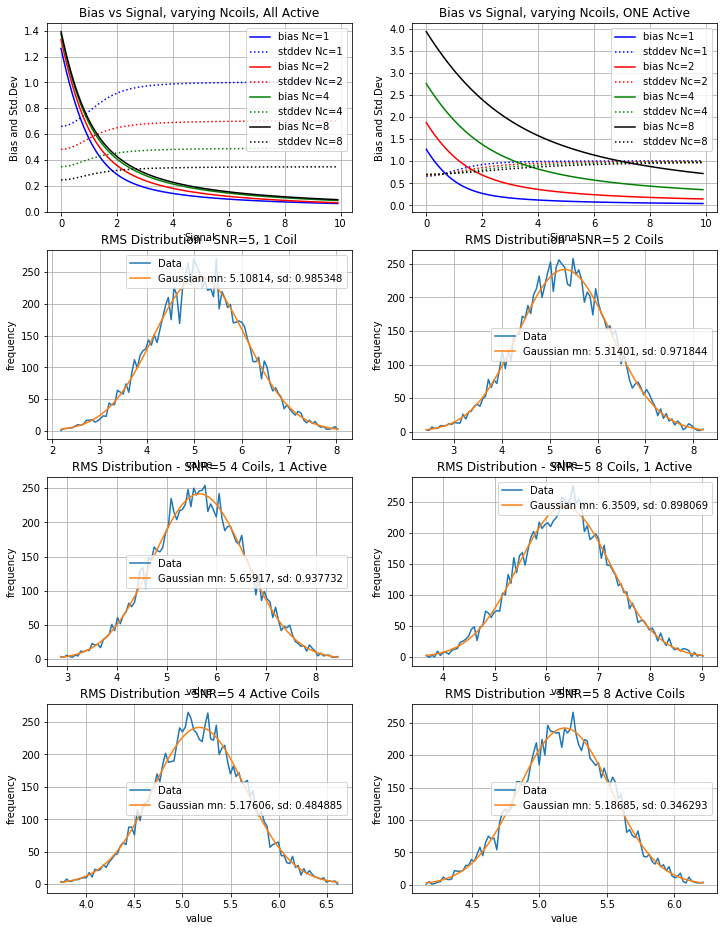

In [8]:
# Now plot bias and std.dev for different numbers of coils
# See notes below
sig = np.arange(0.0,10.0,0.1)  # Signal from 0 to 10
sig = np.expand_dims(sig,axis=1)
fig = plt.figure(figsize=(12.,16.))
plt.subplot(4,2,1)

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,Nc=1)  # 1 coil
plt.plot(sig,sigbias,'b-',label='bias Nc=1')
plt.plot(sig,sigstd,'b:',label='stddev Nc=1')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,Nc=2)  # 2 coils, both active
plt.plot(sig,sigbias,'r-',label='bias Nc=2')
plt.plot(sig,sigstd,'r:',label='stddev Nc=2')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,Nc=4)  # 4 coils, all active
plt.plot(sig,sigbias,'g-',label='bias Nc=4')
plt.plot(sig,sigstd,'g:',label='stddev Nc=4')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,Nc=8)  # 8 coils, all active
plt.plot(sig,sigbias,'k-',label='bias Nc=8')
plt.plot(sig,sigstd,'k:',label='stddev Nc=8')
mrs.lplot('Signal','Bias and Std.Dev','Bias vs Signal, varying Ncoils, All Active')
plt.legend()

print("================================")
plt.subplot(4,2,2)

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,csens=np.array([[1]]))  # 1 coil, 1 active
plt.plot(sig,sigbias,'b-',label='bias Nc=1')
plt.plot(sig,sigstd,'b:',label='stddev Nc=1')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,csens=np.array([[1,0]]))  # 2 coils, 1 active
plt.plot(sig,sigbias,'r-',label='bias Nc=2')
plt.plot(sig,sigstd,'r:',label='stddev Nc=2')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,csens=np.array([[1,0,0,0]]))  #4 coils, 1 active
plt.plot(sig,sigbias,'g-',label='bias Nc=4')
plt.plot(sig,sigstd,'g:',label='stddev Nc=4')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,csens=np.array([[1,0,0,0,0,0,0,0]]))  # 8 coils, 1 active
plt.plot(sig,sigbias,'k-',label='bias Nc=8')
plt.plot(sig,sigstd,'k:',label='stddev Nc=8')
mrs.lplot('Signal','Bias and Std.Dev','Bias vs Signal, varying Ncoils, ONE Active')
plt.legend()
# Now plot distributions.

rmssig = mrs.rmscoilnoise(sig,csens=np.array([[1]]))[0]
plt.subplot(4,2,3)
h=mrs.ghist(rmssig[50,:],bins=100,gtitle='RMS Distribution - SNR=5, 1 Coil')

rmssig = mrs.rmscoilnoise(sig,csens=np.array([[1,0]]))[0]
plt.subplot(4,2,4)
h=mrs.ghist(rmssig[50,:],bins=100,gtitle='RMS Distribution - SNR=5 2 Coils')

rmssig = mrs.rmscoilnoise(sig,csens=np.array([[1,0,0,0]]))[0]
plt.subplot(4,2,5)
h=mrs.ghist(rmssig[50,:],bins=100,gtitle='RMS Distribution - SNR=5 4 Coils, 1 Active')

rmssig = mrs.rmscoilnoise(sig,csens=np.array([[1,0,0,0,0,0,0,0]]))[0]
plt.subplot(4,2,6)
h=mrs.ghist(rmssig[50,:],bins=100,gtitle='RMS Distribution - SNR=5 8 Coils, 1 Active')


rmssig = mrs.rmscoilnoise(sig,Nc=4)[0]
plt.subplot(4,2,7)
h=mrs.ghist(rmssig[50,:],bins=100,gtitle='RMS Distribution - SNR=5 4 Active Coils')

rmssig = mrs.rmscoilnoise(sig,Nc=8)[0]
plt.subplot(4,2,8)
h=mrs.ghist(rmssig[50,:],bins=100,gtitle='RMS Distribution - SNR=5 8 Active Coils')





### Notes here:
If normalizing by $\sqrt{N_{c}}$ or similar, and all coils receive signal,
1. The bias is pretty similar regardless of the number of coils, at SNR=0.  This is the background noise _mean_.  The background noise standard deviation will decrease with averaging over multiple coils.
1. The bias decreases with SNR, though a little more slowly with more coils.  
1. At a reasonable SNR (over about 4) the standard deviation drops as $1/\sqrt{Nc}$

If not normalizing by $\sqrt{N_{c}}$ (This lets us measure bias when only one coil is sensitive to signal)
1. The bias increases, because noise is added in from all coils, and only one contributes signal.
1. The standard deviation actually decreases slightly.  For 2 coils, note the combination is $S = \sqrt{|S_1|^2 + S_1 n_1^\ast + S_1^\ast n_1 + |n_1|^2 + |n_2|^2}$.  Adding noise from coil 2 ($n_2$) increases bias (clear) but does not increase standard deviation (less obvious, at least to me!)
    

## D. Correlated Noise
So far we assumed the coils are uncorrelated.  With MRI coils this is usually a good assumption.  In the worst case, the noise is completely correlated (i.e. identical) between coils.  This extreme case is shown here.


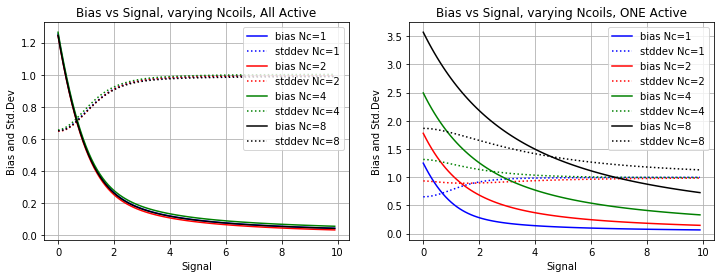

In [5]:
# Now plot bias and std.dev for different numbers of coils
# See notes below
sig = np.arange(0.0,10.0,0.1)  # Signal from 0 to 10
sig = np.expand_dims(sig,axis=1)
fig = plt.figure(figsize=(12.,4.))
plt.subplot(1,2,1)

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,cov=np.ones((1,1)))
plt.plot(sig,sigbias,'b-',label='bias Nc=1')
plt.plot(sig,sigstd,'b:',label='stddev Nc=1')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,cov=np.ones((2,2)))
plt.plot(sig,sigbias,'r-',label='bias Nc=2')
plt.plot(sig,sigstd,'r:',label='stddev Nc=2')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,cov=np.ones((4,4)))
plt.plot(sig,sigbias,'g-',label='bias Nc=4')
plt.plot(sig,sigstd,'g:',label='stddev Nc=4')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,cov=np.ones((8,8)))
plt.plot(sig,sigbias,'k-',label='bias Nc=8')
plt.plot(sig,sigstd,'k:',label='stddev Nc=8')
mrs.lplot('Signal','Bias and Std.Dev','Bias vs Signal, varying Ncoils, All Active')
plt.legend()

plt.subplot(1,2,2)

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,csens=np.array([[1]]))
plt.plot(sig,sigbias,'b-',label='bias Nc=1')
plt.plot(sig,sigstd,'b:',label='stddev Nc=1')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,csens=np.array([[1,0]]),cov=np.ones((2,2)))
plt.plot(sig,sigbias,'r-',label='bias Nc=2')
plt.plot(sig,sigstd,'r:',label='stddev Nc=2')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,csens=np.array([[1,0,0,0]]),cov=np.ones((4,4)))
plt.plot(sig,sigbias,'g-',label='bias Nc=4')
plt.plot(sig,sigstd,'g:',label='stddev Nc=4')

(rmssig,sigbias,sigstd) = mrs.rmscoilnoise(sig,csens=np.array([[1,0,0,0,0,0,0,0]]),cov=np.ones((8,8)))
plt.plot(sig,sigbias,'k-',label='bias Nc=8')
plt.plot(sig,sigstd,'k:',label='stddev Nc=8')
mrs.lplot('Signal','Bias and Std.Dev','Bias vs Signal, varying Ncoils, ONE Active')
plt.legend()


### Note:  Correlated Noise
If the noise is completely correlated, then there are 2 cases:
1. If all coils contribute signal, then the signal is identical to that of a single coil.  The benefit of averaging is completely lost.
1. If one coil contributes signal, the noise bias is a bit smaller for low signal, but the standard deviation is larger (not surprising).
1. If one coil contributes signal, at higher signal the bias is similar to the case with uncorrelated noise.


## Multiple Coils - Using Sensitivities

-- WORKING ON THIS STILL! --

Intuitively we should do much better if we know the coil sensitivities, as we can then ignore far-away coils that are just adding noise to the image(!).  Furthermore, we can rephase the signals when the sensitivities are complex, so that we preserve the complex signal.

### Two-Coil Case
In a simple case, we take the signal from 2 coils.  Rephasing the signal has the same effect as assuming the signals are real-valued and the coil sensitivities $C_i$ are real-valued.  In the simple two-coil case (1) where both coils receive equaly signal, $S = \frac{1}{2}(S_1+S_2)$.  Notably this is real-valued, and will have Gaussian noise with variance $\frac{1}{2}$ as much as the original noise variance, leading to a $\sqrt{2}$ improvement in SNR as expected.  Remember this is a best-case scenario!  In general the combination is $S = \sum_i w_i S_i$.

...


In [6]:
Nc = 3 # 3 coils 
c = np.zeros((Nx,Nc)) 
c[:,0]=mrs.gaussian(x,Nx/4,Nx/8)*1.0 # coil 1 
c[:,1]=mrs.gaussian(x,Nx/2,Nx/8)*0.6 # coil 2
c[:,2]=mrs.gaussian(x,3*Nx/4,Nx/8)*0.8 # coil 3 
plt.plot(x,c)

NameError: name 'Nx' is not defined

## Noise Co-variance
The noise covariance matrix, often called $\Psi$ characterizes multi-dimensional gaussian noise.  Note this differs from the correlation matrix, which is normalized by the square root of the products of diagonal elements in the same row and column as each element in the covariance matrix.  An uncorrelated noise matrix is diagonal. 


## Reduction
Algorithms such as SENSE can reconstruct images from reduced sampling datasets.  The reduction factor is called $R$.  For this example we begin with $R=1$, and note that the $R=1$-SENSE reconstruction is often better than a simple RMS coil combination. 


## SENSE Combination Matrix
The SENSE reconstruction matrix is as follows:


## g Factor
The geometry or $g$ factor is below.  Note that for $R=1$ the $g$ factor is 1.


## Channel Signals
The channel signals are shown below, simply the coil sensitivity multiplied by the image, with noise added.  The noise is generated according to the covariance matrix $\Psi$ (both real and imaginary noise).


## SENSE Reconstuction
The images reconstructed with SENSE and with RMS are shown below.  Note that the RMS image is not normalized as it is blind to the sensitivities.


## Pseudo-Multiple Noise Propagation
A good way to generate "actual" noise is to repeat the reconstruction $N$ times, and generate mean and standard deviation (as well as the whole noise distribution).  These can be done for both SENSE and RMS.  The actual histograms at one pixel (peak of the triangle) are shown as well, with a gaussian fit.  


In [ ]:
Noise

## Signal
We create a simple 1D signal that consists of a triangle and a half-circle.  This approach could be used with 2D images similarly.



In [ ]:
# Create Signal - for next parts
Nx=256

m = np.zeros(Nx)
m[np.int(Nx/8):np.int(Nx/4)]=np.arange(0,Nx/8)       #Ramp up
m[np.int(Nx/4):np.int(3*Nx/8)]=np.arange(Nx/8,0,-1)  #Ramp down
scirc = np.arange(-Nx/8,Nx/8,1)
scirc = np.sqrt(np.power((Nx/8),2)-scirc*scirc)/2      #Semi-circle, half amplitude
m[np.int(5.* Nx/8):np.int(7.* Nx/8)] = scirc            
x = np.arange(0,Nx)
plt.plot(x,m)
mrs.lplot('x','signal','Basic Signal')